In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [141]:
emails_sent_raw = pd.read_csv('Data/emails_sent.csv')

In [142]:
emails_sent_raw.columns = emails_sent_raw.columns.str.lower()
emails_sent_raw['sent_at'] = pd.to_datetime(emails_sent_raw['sent_at']).dt.tz_localize(None).dt.date
emails_sent_raw = emails_sent_raw.fillna(0)

In [143]:
emails_sent_raw.head(7)

,user_id,campaign_id,variation_name,sent_at,opened_email
0,2084572,55e05c6619f3b0b58685269d0fbb56c9,Original,2020-02-17,True
1,2084572,acf16f627094695a3bb33e7546c36df9,Joyful shot- YESPLEASE,2020-02-16,0
2,2084572,1daa83a96adf94499d57c8a0bd20d428,offer displayed,2020-02-17,0
3,2084572,cc2c741c0cfbde4c6f43231c4f53a767,Original,2020-02-17,True
4,2084572,f8519c3e9219cc5f8f762fddda8d3f22,Original,2020-02-18,True
5,2084572,19c4d97feb334920a000b5acdb5cb7b9,[No name for this variation],2020-06-23,0
6,2084572,6b4a1dcdba884f8746f345bd054f6257,CI 2019 MentionMe,2020-02-24,True


In [144]:
camp_days = pd.DataFrame(emails_sent_raw.groupby('sent_at').user_id.nunique().rename('users_received')).reset_index()

camp_days = (camp_days.merge(emails_sent_raw.groupby('sent_at').campaign_id.nunique().rename('campaign_type')
                            , on = 'sent_at', how = 'left' ))

emails_sent_raw['opened_email'] = np.where(emails_sent_raw['opened_email'] == 0, 'not_opened', 'opened')

read = (pd.DataFrame(emails_sent_raw.groupby(['sent_at', 'opened_email']).opened_email.count().rename('val')
                     .reset_index()).pivot(index = 'sent_at', columns = 'opened_email', values = 'val')
                    .fillna(0).reset_index())

camp_days = camp_days.merge(read, on = 'sent_at', how = 'left')  
camp_days = camp_days.merge(emails_sent_raw.groupby('sent_at').campaign_id.count().rename('camp_volume')
                            , on = 'sent_at', how = 'left')

In [145]:
orders = pd.read_csv('Data/orders_days.csv')
orders['created_at'] = pd.to_datetime(orders['created_at'])

In [146]:
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))

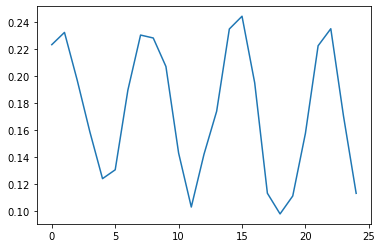

In [147]:
xcov_daily = [crosscorr(orders.new_users, camp_days.camp_volume, lag=i) for i in range(25)]
plt.plot(xcov_daily)

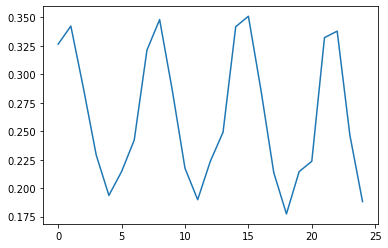

In [148]:
xcov_daily = [crosscorr(orders.users, camp_days.users_received, lag=i) for i in range(25)]
plt.plot(xcov_daily)


1, 8, 16 days

In [149]:
corr_days = [1, 8, 16]

for i in corr_days:
    camp_days['camp_day'] = camp_days.sent_at + pd.DateOffset(days = i)
    temp = camp_days.drop('sent_at', axis =1)
    temp.columns = temp.columns + '_' + str(i)
    orders = orders.merge(temp, left_on = 'created_at', right_on = 'camp_day' + '_' + str(i), how = 'left')
  

In [150]:
disc3 = 1
disc4 = 2, 12
disc5 = 1, 13

In [151]:
orders['disc1_pre_3days'] = orders.sort_values('created_at').disc1.shift(1).rolling(3).sum()
orders['disc1_pre_6day'] = orders.sort_values('created_at').disc1.shift(6)
orders['disc1_pre_14dat'] = orders.sort_values('created_at').disc1.shift(14)

orders['disc2_pre_4days'] = orders.sort_values('created_at').disc2.shift(1).rolling(4).sum()
orders['disc2_pre_7day'] = orders.sort_values('created_at').disc2.shift(7)
orders['disc2_pre_14day'] = orders.sort_values('created_at').disc2.shift(14)

orders['disc3_pre_1day'] = orders.sort_values('created_at').disc3.shift(1)

orders['disc4_pre_2day'] = orders.sort_values('created_at').disc4.shift(2)
orders['disc5_pre_1day'] = orders.sort_values('created_at').disc5.shift(1)
orders['disc5_pre_13day'] = orders.sort_values('created_at').disc5.shift(13)

other_features = ['products', 'new_users', 'volume', 'full_revenue']

for i in other_features:
    orders[str(i)+'_pre_3days'] = orders.sort_values('created_at')[i].shift(1).rolling(3).sum()
    orders[str(i)+'_pre_7day'] = orders.sort_values('created_at')[i].shift(7)
    orders[str(i)+'_pre_14day'] = orders.sort_values('created_at')[i].shift(14)



In [152]:
orders['year'] = orders['created_at'].dt.year
orders['month'] = orders['created_at'].dt.month

In [172]:
orders['users'] = orders['users'] - orders['new_users']

In [173]:
orders =  orders.iloc[14:]
orders = orders.fillna(0)
orders = (orders[((orders['campaign_type_1'] != 0) |
                 (orders['campaign_type_8'] != 0) | (orders['campaign_type_16'] != 0))])

In [174]:
orders.columns

Index(['Unnamed: 0', 'created_at', 'volume', 'revenue', 'full_revenue',
       'disc1', 'disc2', 'disc3', 'disc4', 'disc5', 'Magento', 'Mobile',
       'Website', 'import', 'products', 'users', 'new_users',
       'users_received_1', 'campaign_type_1', 'not_opened_1', 'opened_1',
       'camp_volume_1', 'camp_day_1', 'users_received_8', 'campaign_type_8',
       'not_opened_8', 'opened_8', 'camp_volume_8', 'camp_day_8',
       'users_received_16', 'campaign_type_16', 'not_opened_16', 'opened_16',
       'camp_volume_16', 'camp_day_16', 'disc1_pre_3days', 'disc1_pre_6day',
       'disc1_pre_14dat', 'disc2_pre_4days', 'disc2_pre_7day',
       'disc2_pre_14day', 'disc3_pre_1day', 'disc4_pre_2day', 'disc5_pre_1day',
       'disc5_pre_13day', 'products_pre_3days', 'products_pre_7day',
       'products_pre_14day', 'new_users_pre_3days', 'new_users_pre_7day',
       'new_users_pre_14day', 'volume_pre_3days', 'volume_pre_7day',
       'volume_pre_14day', 'full_revenue_pre_3days', 'full_revenue

In [178]:
user_dataset = orders.drop(columns = {'Unnamed: 0'
                                        , 'created_at'
                                        , 'volume'
                                        , 'revenue'
                                        , 'full_revenue'
                                        , 'disc1'
                                        , 'disc2'
                                        , 'disc3'
                                        , 'disc4'
                                        , 'disc5'
                                        , 'Magento'
                                        , 'Mobile'
                                        , 'Website'
                                        , 'import'
                                        , 'products'
                                        , 'new_users'
                                        , 'camp_day_1'
                                        , 'camp_day_8'
                                        , 'camp_day_16'
                                        , 'not_opened_1'
                                        , 'not_opened_8'
                                        , 'not_opened_16'}, axis = 1).fillna(0)

In [179]:
user_dataset.to_csv('Data/user_dataset.csv')

In [180]:
data_grid_dataset = orders.drop(columns = {'Unnamed: 0'
                                        , 'revenue'
                                        , 'full_revenue'
                                        , 'Magento'
                                        , 'Mobile'
                                        , 'Website'
                                        , 'import'
                                        , 'products'
                                        , 'new_users'
                                        , 'camp_day_1'
                                        , 'camp_day_8'
                                        , 'camp_day_16'
                                        , 'not_opened_1'
                                        , 'not_opened_8'
                                        , 'not_opened_16'}, axis = 1).fillna(0)

In [181]:
data_grid_dataset.to_csv('Data/data_grid_dataset.csv')